In [ ]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2
%cd Depth-Anything-V2/metric_depth
!pip install -r requirements.txt

from IPython.display import clear_output
clear_output()

In [ ]:
!mkdir checkpoints
!cp /content/drive/MyDrive/Colab\ Notebooks/depth-estimation/Depth-Anything/depth_anything_v2_metric_vkitti_vitl.pth checkpoints
!cp /content/drive/MyDrive/Colab\ Notebooks/depth-estimation/Depth-Anything/depth_anything_v2_metric_hypersim_vitl.pth checkpoints

In [ ]:
import cv2
import torch

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 20 # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.cuda()
model.eval()

from IPython.display import clear_output
clear_output()

In [ ]:
# helper functions
import os
import numpy as np

MAX_RANGE = max_depth # for DepthAnything v2, change in other models

outdoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/outdoor/*/*/*.png'
indoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/indoors/*/*/*.png'
nyu_folder_path = '/content/drive/MyDrive/PW/Praca/NYUv2/rgb/*.jpg'
stray_folder_path = '/content/drive/MyDrive/PW/Praca/stray_dataset/*/first_frame.png'
stray_indoor_folder_path = '/content/drive/MyDrive/PW/Praca/stray_indoor/*/first_frame.png'
kitti_folder_path = '/content/drive/MyDrive/PW/Praca/kitti_evaluation/image/*.png'
vkitti2_folder_path = '/content/drive/MyDrive/PW/Praca/vkitti2_evaluation/vkitti_2.0.3_rgb/*/15-deg-left/frames/rgb/Camera_0/*.jpg'
taskonomy_folder_path = '/content/drive/MyDrive/PW/Praca/Taskonomy/rgb/allensville/*.png'
actual_path = indoor_folder_path

def get_gt_path(image_path):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        gt_path = image_path.replace('.png', '_depth.npy')
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        gt_path = image_path.replace('first_frame.png', 'depth/000000.png')
    elif actual_path == nyu_folder_path:
        dir_name, image_name = os.path.split(image_path)
        gt_path = os.path.join(dir_name.replace('rgb', 'depth'), image_name.replace('jpg', 'npy'))
    elif actual_path == vkitti2_folder_path:
        gt_path = image_path.replace('rgb', 'depth').replace('jpg', 'png')
    elif actual_path == kitti_folder_path:
        gt_path = image_path.replace('image', 'groundtruth_depth', 2)
    elif actual_path == taskonomy_folder_path:
        gt_path = image_path.replace('rgb', 'depth_euclidean')
    return gt_path

def get_error_mask(gt):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        if MAX_RANGE:
            mask = (gt > 0.6) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0.6) & (gt < 350)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        mask = (gt > 0.3) & (gt < 5)
    elif actual_path == nyu_folder_path:
        mask = (gt > 0) & (gt < 10)
    elif actual_path == vkitti2_folder_path:
        if MAX_RANGE:
            mask = (gt > 2.5) & (gt < MAX_RANGE)
        else:
            mask = (gt > 2.5) & (gt < 85)
    elif actual_path == kitti_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0)
    elif actual_path == taskonomy_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0) & (gt < 128)
    return mask

def get_depth_gt(gt_path):
    if actual_path in [outdoor_folder_path, indoor_folder_path]:
        depth_gt = np.load(gt_path).squeeze()
    elif actual_path == nyu_folder_path:
        depth_gt = np.load(gt_path)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        depth_gt = cv2.imread(gt_path, -1) / 1000
    elif actual_path == vkitti2_folder_path:
        depth_gt = cv2.imread(gt_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 100
    elif actual_path == kitti_folder_path:
        depth_gt = cv2.imread(gt_path, 0)
    elif actual_path == taskonomy_folder_path:
        depth_gt = cv2.imread(gt_path, -1) / 512
    return depth_gt

def compute_errors(gt, pred):
    mask = get_error_mask(gt)
    gt = gt[mask]
    pred = pred[mask]

    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean((np.abs(gt - pred) / gt))
    sq_rel = np.mean((((gt - pred) ** 2) / gt))

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = (np.log(pred) - np.log(gt))
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)

In [ ]:
import time, glob
from tqdm import tqdm

results = []
images = [i for i in glob.iglob(actual_path, recursive=True)]
for image_path in tqdm(images):
    gt_path = get_gt_path(image_path)
    start_time = time.time()

    raw_img = cv2.imread(image_path)
    pred_depth = model.infer_image(raw_img)

    exec_time = (time.time() - start_time)
    if actual_path in [stray_folder_path, stray_indoor_folder_path]:
        pred_depth = cv2.resize(pred_depth, (256, 192))
    results.append({'pred_depth': pred_depth, 'gt_path': gt_path, 'exec_time': exec_time})

100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


In [ ]:
import numpy as np
import cv2

# compute errors on results
metrics = []
print("computing errors...")
for result in tqdm(results):
    depth_gt = get_depth_gt(result['gt_path'])
    metrics.append({"exec_time": result['exec_time'], **compute_errors(depth_gt, result['pred_depth'])})

# compute mean values
values_list = {
    "a1": [],
    "a2": [],
    "a3": [],
    "abs_rel": [],
    "rmse": [],
    "log_10": [],
    "rmse_log": [],
    "silog": [],
    "sq_rel": [],
    "exec_time": [],
}
for metric in metrics:
    for key, value in metric.items():
        values_list[key].append(value)

mean_values = {}
for key, value in values_list.items():
    mean_values[key] = sum(value) / len(value)

print('\n', mean_values)

computing errors...


100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


 {'a1': 0.39194495956438263, 'a2': 0.9321507475995536, 'a3': 0.9661804852812628, 'abs_rel': 0.3552633578296745, 'rmse': 1.1894946623904183, 'log_10': 0.12360097175953672, 'rmse_log': 0.3029482963479016, 'silog': 9.368239951477134, 'sq_rel': 0.6867346238855572, 'exec_time': 2.643849297573692}


3.029
4.019002


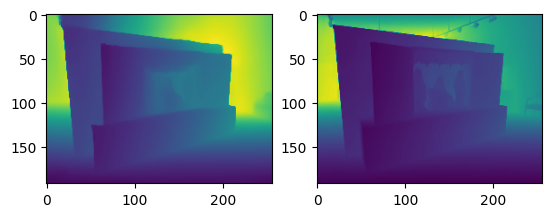

In [ ]:
# debug set

num = 5
y, x = (150, 50)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

print(gt_depth[y][x])
print(pred_depth[y][x])

import matplotlib.pyplot as plt
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(gt_depth)
f.add_subplot(1,2, 2)
plt.imshow(pred_depth)
plt.show(block=True)

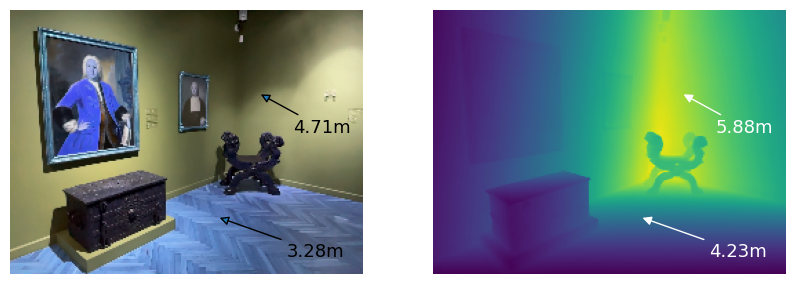

In [ ]:
# Stray indoor visualisation

num = 9
y, x = (60, 180)
y2, x2 = (150, 150)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (25, -25)
xytext2 = (50, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

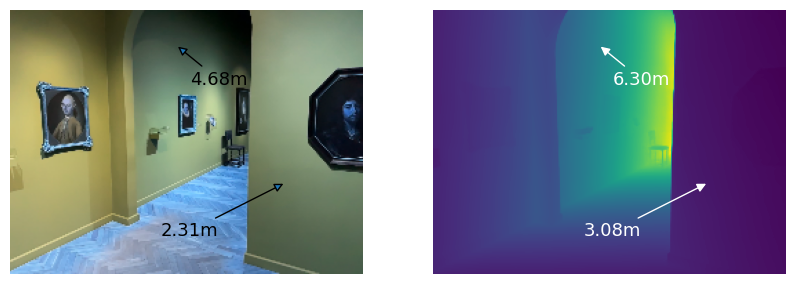

In [ ]:
# Stray indoor visualisation

num = 7
y, x = (25, 120)
y2, x2 = (125, 200)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (10, -25)
xytext2 = (-90, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

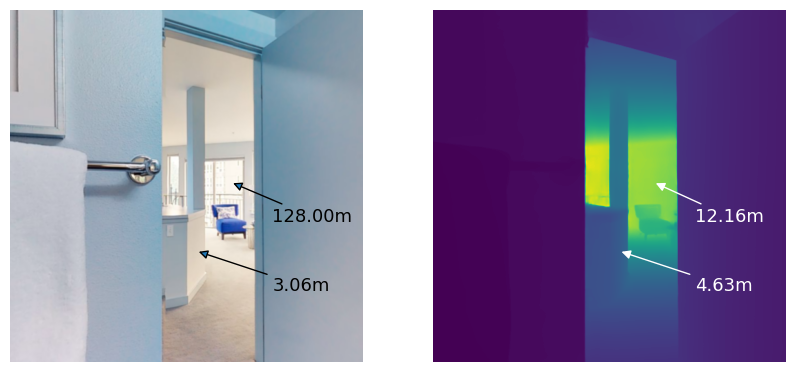

In [ ]:
# Taskonomy visualisation

num = 9
y, x = (250, 320)
y2, x2 = (350, 270)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

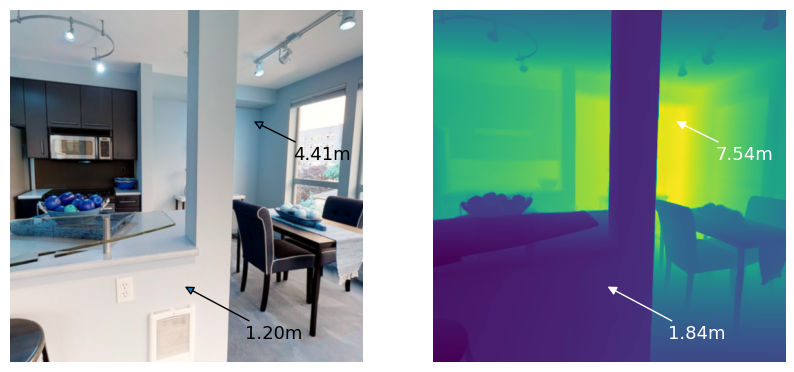

In [ ]:
# Taskonomy visualisation

num = 3
y, x = (160, 350)
y2, x2 = (400, 250)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (45, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

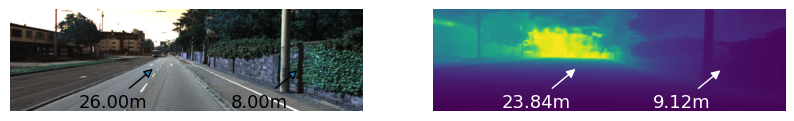

In [ ]:
# KITTI visualisation

num = 4
y, x = (205, 1000)
y2, x2 = (200, 500)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('groundtruth_depth', 'image', 2)

fontsize = 13
xytext1 = (-50, -24)
xytext2 = (-55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

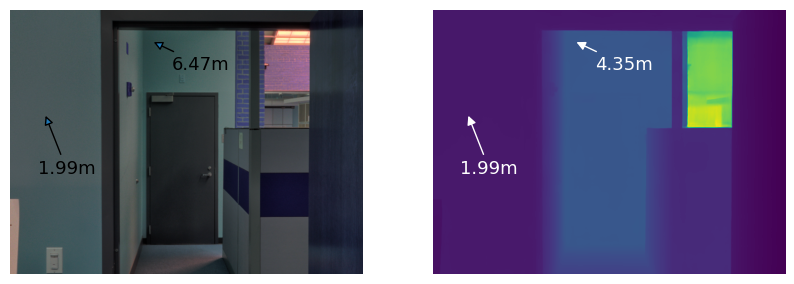

In [ ]:
# DIODE indoor visualisation

num = 1
y, x = (300, 100)
y2, x2 = (90, 410)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('_depth.npy', '.png')

fontsize = 13
xytext1 = (-5, -40)
xytext2 = (15, -17)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)